<a href="https://colab.research.google.com/github/taliafabs/sta365-winter2025/blob/main/sta365_hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STA365 Week 6 Homework: Hamiltonian Monte Carlo

## Question 1
We previously considered the normal-gamma specification

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

We want to sample from $p(\mu, \sigma^2, \nu | x) \propto p(\mu, \sigma^2, \nu, x) = p(x|\mu, \sigma^2, \nu) p(\mu) p(\sigma^2) p(\nu)$

*   The *likelihood* is:

  $$
  p(x|\mu, \sigma^2, \nu) = \prod_{i=1}^n \frac{Γ(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2}) \sqrt{\pi \nu \sigma^2}} \left( 1 + \frac{1}{\nu} \frac{(x_i - \mu)^2}{\sigma^2} \right)
  $$

*   The normal *prior* on $\mu$ is:
 $$p(\mu) =  \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2}$$
*   The half-normal *prior* on $\sigma^2$ is:
 $$p(\sigma^2) = \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) $$
*   The discrete uniform *prior* on $\nu$ is:
$$
p(\nu = i) = \begin{cases}
\frac{1}{100} & \text{for } i = 1, \dots, 100 \\
0 & \text{otherwise}
\end{cases}
$$

\begin{align*}
p(\mu, \sigma^2, \nu, x) &= \left( \prod_{i=1}^n \frac{Γ(\frac{\nu+1}{2})}{\Gamma(\frac{\nu}{2}) \sqrt{\pi \nu \sigma^2}} \left( 1 + \frac{1}{\nu} \frac{(x_i - \mu)^2}{\sigma^2} \right) \right)  \left(\sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2}\right) \left( \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) \right) \left( \begin{cases}
\frac{1}{100} & \text{for } i = 1, \dots, 100 \\
0 & \text{otherwise}
\end{cases}
\right)
\\
&\propto \prod_{i=1}^n \left( 1 + \frac{1}{\nu} \frac{(x_i - \mu)^2}{\sigma^2} \right)^{-\frac{\nu+1}{2}}
\cdot e^{-\frac{\tau_0}{2}(\mu - \mu_0)^2} \cdot \exp \left(-\frac{\sigma^2}{2 \sigma_0^2}\right) 1_{[0, \infty]}(\sigma^2)
\end{align*}







In [13]:
# not starting on log scale do it later
np.random.seed(123)
n = 100 # small-ish sample size
mu_0, tau_0, sigma2_0 = 0, 1, 1

# Simulate synthetic data from a student's t distribution
x = stats.t(loc=mu_0, scale=sigma2_0, df=n-1).rvs(n)

# Priors
def prior_mu(mu):
  return stats.norm(loc=mu_0, scale=tau_0).pdf(mu)

def prior_sigma2(sigma2):
  return stats.halfnorm(scale=sigma2_0).pdf(sigma2)

def prior_nu(nu):
  return stats.uniform(loc=0, scale=100).pdf(nu)

# Likelihood
def likelihood(x, mu, sigma2, nu):
  return np.prod(stats.t(loc=mu, scale=np.sqrt(sigma2), df=nu).pdf(x))

# Target posterior distributions
def target_posterior_mu(mu, sigma2, nu):
  return likelihood(x, mu, sigma2, nu) * prior_mu(mu)

def target_posterior_sigma2(mu, sigma2, nu):
  return likelihood(x, mu, sigma2, nu) * prior_sigma2(sigma2)

def target_posterior_nu(mu, sigma2, nu):
  return likelihood(x, mu, sigma2, nu) * prior_nu(nu)

# MCMC Settings
C, G = 2, 5000    # 2 chain, 5000 samples
burn_in = 30


def metropolis_gibbs_sampler(C=C, G=G, mu_0=mu_0, sigma2_0=sigma2_0):

  mu_samples = np.zeros((C, G))
  sigma2_samples = np.zeros((C, G))
  nu_samples = np.zeros((C, G))
  mu_samples[:, 0] = mu_0
  sigma2_samples[:, 0] = sigma2_0
  nu_samples[:, 0] = np.random.uniform(low=0, high=100, size=C)
  epsilon = 1e-10

  # Metropolis within gibbs sampler
  for c in range(C):
    for g in range(1, G):
      old_sigma2, old_mu, old_nu = sigma2_samples[c, g-1], mu_samples[c, g-1], nu_samples[c, g-1]

      # ----- Metropolis update for sigma2 -----
      sigma2_proposal = stats.halfnorm(scale=0.5) # adjust this scale based on acceptance rate
      sigma2_tilde = sigma2_proposal.rvs()
      sigma2_numerator = target_posterior_sigma2(old_mu, sigma2_tilde, old_nu) * sigma2_proposal.pdf(old_sigma2)
      sigma2_denominator = target_posterior_sigma2(old_mu, old_sigma2, old_nu) * sigma2_proposal.pdf(sigma2_tilde)
      if sigma2_numerator == 0 or sigma2_denominator == 0: # just reject zeros
        sigma2_samples[c, g] = old_sigma2
      # implement acceptance probability on a log scale
      else:
        log_sigma2_acceptance_ratio = np.log(sigma2_numerator) - np.log(sigma2_denominator) # log the acceptance ratio
        log_r_sigma2 = np.log(np.random.uniform(low=0, high=1)) # log the r
        log_sigma_acceptance_prob = min(0, log_sigma2_acceptance_ratio) # get the log acceptance probability
        if log_r_sigma2 < log_sigma_acceptance_prob:
          sigma2_samples[c, g] = sigma2_tilde
        else:
          sigma2_samples[c, g] = old_sigma2

      # ----- Metropolis update for mu -----
      mu_proposal = stats.norm(loc=old_mu, scale=0.1)
      mu_tilde = mu_proposal.rvs()
      mu_numerator = target_posterior_mu(mu_tilde, old_sigma2, old_nu) * mu_proposal.pdf(old_mu)
      mu_denominator = target_posterior_mu(old_mu, old_sigma2, old_nu) * mu_proposal.pdf(mu_tilde)
      # implementing acceptance probability on log scale
      log_mu_acceptance_ratio = np.log(mu_numerator) -  np.log(mu_denominator)
      log_r_mu = np.log(np.random.uniform(low=0, high=1))
      log_mu_acceptance_prob = min(0, log_mu_acceptance_ratio)
      if log_r_mu < log_mu_acceptance_prob:
        mu_samples[c, g] = mu_tilde
      else:
        mu_samples[c, g] = old_mu

      # ----- Metropolis update for nu -----
      # nu_proposal = np.random.uniform(low=0, high=100, size=C)
      nu_proposal = stats.uniform(loc=0, scale=100)
      nu_tilde = nu_proposal.rvs()
      nu_numerator = target_posterior_nu(old_mu, old_sigma2, nu_tilde) * nu_proposal.pdf(old_nu)
      nu_denominator = target_posterior_nu(old_mu, old_sigma2, old_nu) * nu_proposal.pdf(nu_tilde)
      # implementing acceptance probability on log scale
      log_nu_acceptance_ratio = np.log(nu_numerator) - np.log(nu_denominator)
      log_r_nu = np.log(np.random.uniform(low=0, high=1))
      log_nu_acceptance_prob = min(0, log_nu_acceptance_ratio)
      if log_r_nu < log_nu_acceptance_prob:
        nu_samples[c, g] = nu_tilde
      else:
        nu_samples[c, g] = old_nu

  # return the chains
  return mu_samples, sigma2_samples, nu_samples

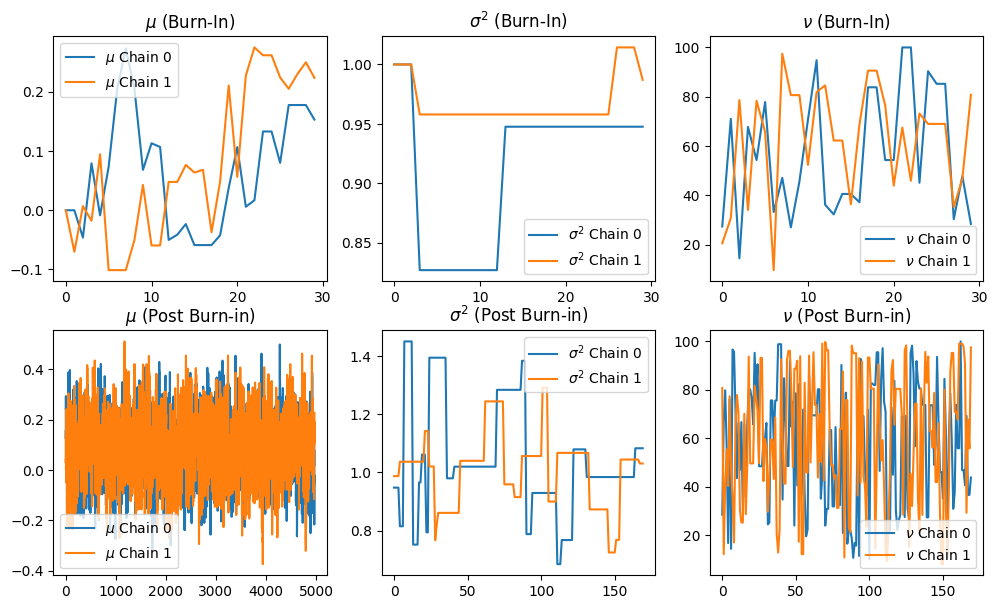

In [14]:
mu_samples, sigma2_samples, nu_samples = metropolis_gibbs_sampler(C=C, G=G, mu_0=mu_0, sigma2_0=sigma2_0)

burn_in = 30
demo = 200
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
ax[0, 0].set_title(r"$\mu$ (Burn-In)")
ax[0, 1].set_title(r"$\sigma^2$ (Burn-In)")
ax[0, 2].set_title(r"$\nu$ (Burn-In)")
ax[1, 0].set_title(r"$\mu$ (Post Burn-in)")
ax[1, 1].set_title(r"$\sigma^2$ (Post Burn-in)")
ax[1, 2].set_title(r"$\nu$ (Post Burn-in)")

for c in range(C):
  mu_pre = mu_samples[c, :burn_in]
  sigma2_pre = sigma2_samples[c, :burn_in]
  nu_pre = nu_samples[c, :burn_in]
  mu_post = mu_samples[c, burn_in:]
  sigma2_post = sigma2_samples[c, burn_in:demo]
  nu_post = nu_samples[c, burn_in:demo]

  # Burn-in period plots
  ax[0, 0].plot(mu_pre, label="$\\mu$ Chain "+str(c))
  ax[0, 1].plot(sigma2_pre, label="$\\sigma^2$ Chain "+str(c))
  ax[0, 2].plot(nu_pre, label="$\\nu$ Chain "+str(c))

  # Post burn-in plots
  ax[1, 0].plot(mu_post, label="$\\mu$ Chain "+str(c))
  ax[1, 1].plot(sigma2_post, label="$\\sigma^2$ Chain "+str(c))
  ax[1, 2].plot(nu_post, label = "$\\nu$ Chain "+str(c))

# add the legends
ax[0,0].legend(); ax[0,1].legend(); ax[0,2].legend()
ax[1,0].legend(); ax[1,1].legend(); ax[1,2].legend()


(array([0.00736065, 0.00768068, 0.01056093, 0.00928082, 0.01088096,
        0.00832073, 0.01504133, 0.01568138, 0.00736065, 0.01664147]),
 array([ 8.04375356, 17.23411994, 26.42448631, 35.61485269, 44.80521907,
        53.99558544, 63.18595182, 72.3763182 , 81.56668458, 90.75705095,
        99.94741733]),
 <BarContainer object of 10 artists>)

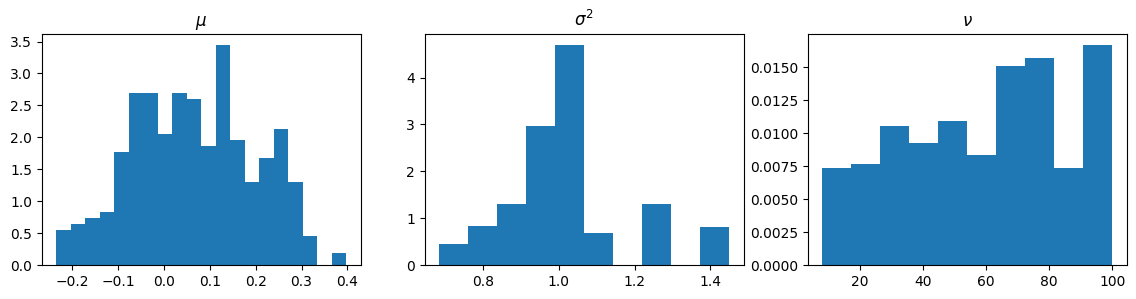

In [19]:
# histograms
fig, ax = plt.subplots(1, 3, figsize=(14,3))

# set the titles
ax[0].set_title(r"$\mu$")
ax[1].set_title(r"$\sigma^2$")
ax[2].set_title(r"$\nu$")

# plot the histograms
ax[0].hist(mu_samples[:, burn_in:demo].flatten(), bins=20, density=True)
ax[1].hist(sigma2_samples[:, burn_in:demo].flatten(), density=True)
ax[2].hist(nu_samples[:, burn_in:demo].flatten(), density=True)

#### Scratch cells for rough work (commented out)

In [ ]:
# SCRATCH CELL
# from math import log
# np.random.seed(123)
# # Initialization
# n = 100 # Sample size
# mu_0, tau_0 = 0, 1 # Priors for mean & precision
# sigma2_0 = 1 # Prior for variance

# # Simulate synthetic data from a student's t distribution
# x = stats.t(loc=mu_0, scale=sigma2_0, df=n-1).rvs(n)

# # Log priors
# def log_prior_mu(mu):
#   return stats.norm(loc=mu_0, scale=tau_0).logpdf(mu)

# def log_prior_sigma2(sigma2):
#   return stats.halfnorm(scale=sigma2_0).logpdf(sigma2)

# def log_prior_nu(nu):
#   return stats.uniform(loc=0, scale=100).logpdf(nu)

# # Log-likelihood for the data x given (mu, sigma2, nu)
# def log_likelihood(x, mu, sigma2, nu):
#   return np.sum(stats.t(loc=mu, scale=sigma2, df=nu).logpdf(x))

# # Target distributions
# def log_target_mu(mu, sigma2, nu):
#   return log_likelihood(x, mu, sigma2, nu) + log_prior_mu(mu)

# def log_target_sigma2(mu, sigma2, nu):
#   return log_likelihood(x, mu, sigma2, nu) + log_prior_sigma2(sigma2)

# def log_target_nu(mu, sigma2, nu):
#   return log_likelihood(x, mu, sigma2, nu) + log_prior_nu(nu)


# # MCMC settings
# C, G = 2, 5000 # total num chains, samples
# burn_in = 30
# mu_samples = np.zeros((C, G)) # chains
# sigma2_samples = np.zeros((C, G))
# nu_samples = np.zeros((C, G))
# mu_samples[:, 0] = mu_0 # samples
# sigma2_samples[:, 0] = tau_0
# nu_samples[:, 0] = np.random.uniform(low=0, high=100, size=C)

# for c in range(C):
#     for g in range(1, G):
#       old_sigma2, old_mu, old_nu = sigma2_samples[c, g-1], mu_samples[c, g-1], nu_samples[c, g-1]
#       # ----- Metropolis update for sigma^2 -----
#       sigma2_proposal = stats.halfnorm(scale=0.1)
#       # sigma2_tilde = sigma2_proposal.rvs()
#       sigma2_tilde = np.abs(sigma2_samples[c, g-1] + sigma2_proposal.rvs)
#       sigma2_numerator= log_target_sigma2(old_mu, sigma2_tilde, old_nu) + np.log(sigma2_proposal.pdf(old_sigma2))
#       sigma2_denominator = log_target_sigma2(old_mu, old_sigma2, old_nu) + np.log(sigma2_proposal.pdf(sigma2_tilde))
#       log_sigma2_acceptance = sigma2_numerator - sigma2_denominator
#       r = min(np.random.uniform(low=0, high=1), np.exp(log_sigma2_acceptance))
#       if log_sigma2_acceptance < np.log(r):
#         sigma2_samples[c, g] = sigma2_tilde
#       else:
#         sigma2_samples[c, g] = old_sigma2

#       # Compute metropolis hastings acceptance ratio on log scale
#       # log_sigma2_acceptance = log_target_sigma2(old_mu, sigma2_tilde, old_nu) - log_target_sigma2(old_mu, old_sigma2, old_nu)

#       # ----- Metropolis update for mu -----
#       mu_proposal = stats.norm(loc=mu_samples[c, g-1], scale=0.1)
#       mu_tilde = mu_proposal.rvs()


#       # ----- Metropolis update for nu -----
#       nu_proposal = np.random.uniform(low=0, high=100, size=C)
#       nu_tilde = nu_proposal.rvs()

## Question 2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*


In [21]:
import pymc as pm
import arviz as az

In [ ]:
# sample sizes
sample_sizes = [100, 200, 1000, 10000]
theta_true, tau_true = 0, 1

# generate data
x1 = stats.t(loc=theta_true, scale=tau_true, df=sample_sizes[0]-1).rvs(sample_sizes[0])
x2 = stats.t(loc=theta_true, scale=tau_true, df=sample_sizes[1]-1).rvs(sample_sizes[1])
x3 = stats.t(loc=theta_true, scale=tau_true, df=sample_sizes[2]-1).rvs(sample_sizes[2])
x4= stats.t(loc=theta_true, scale=tau_true, df=sample_sizes[3]-1).rvs(sample_sizes[3])

def run_model(x_obs):
  model = pm.Model()
  with model:
    # prior parameters
    mu_0 = 0
    mu_prior_n = 1
    sigma_0 = 1
    tau_0 = mu_prior_n * tau_true

    # Priors
    mu = pm.Normal('mu', mu=0, sigma=1)
    sigma2 = pm.HalfNormal('sigma2', sigma=1)
    nu = pm.DiscreteUniform('nu', lower=0, upper=100)

    # Likelihood
    x = pm.StudentT('x_obs',
                    mu=mu,
                    sigma=sigma2,
                    nu=nu,
                    observed=x_obs)

    # Sample
    idata = pm.sample(draws=2000, chains=4, tune=100)

  return idata

# run models
idata1 = run_model(x1)
idata2 = run_model(x2)
idata3 = run_model(x3)
idata4 = run_model(x4)

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

#### Trace plots

In [ ]:
az.plot_trace(idata1)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_trace(idata2)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_trace(idata3)
plt.tight_layout()
plt.show()

In [ ]:
az.plot_trace(idata4)
plt.tight_layout()
plt.show()

####  Forest plots

In [ ]:
# sample size 100
az.plot_forest(idata1,
               var_names=['mu', 'sigma2', 'nu'],
               combined=True,
               hdi_prob=0.95,
               r_hat=True)
plt.tight_layout()
plt.show()

In [ ]:
# sample size 200
az.plot_forest(idata2,
               var_names=['mu', 'sigma2', 'nu'],
               combined=True,
               hdi_prob=0.95,
               r_hat=True)
plt.tight_layout()
plt.show()

In [ ]:
# sample size 1000
az.plot_forest(idata3,
               var_names=['mu', 'sigma2', 'nu'],
               combined=True,
               hdi_prob=0.95,
               r_hat=True)
plt.tight_layout()
plt.show()

In [ ]:
# sample size 10,000
az.plot_forest(idata4,
               var_names=['mu', 'sigma2', 'nu'],
               combined=True,
               hdi_prob=0.95,
               r_hat=True)
plt.tight_layout()
plt.show()

As shown on the forest plots, the 95% high density interval for $\nu$ got narrower and the R-hat value for $\nu$ got closer to 1 as we increased the sample size. At the sample size 100, the R-hat value for $\nu$ was close to 2 (indicating low agreement between chains), whereas it became a lot closer to 1 (indicating much better agreement between chains) by the time I increased the sample size to 10,000. There was more unceratinty about the value of $\nu$ at smaller sample sizes.

#### Bayesian inference and diagnostics with `az.summary`

Sample size 100

In [ ]:
az.summary(idata1, round_to=5)

Sample size 200

In [ ]:
az.summary(idata2, round_to=5)

Sample size 1000

In [ ]:
az.summary(idata3, round_to=5)

Sample size 10,000

In [ ]:
az.summary(idata4, round_to=5)

#### Comparing autocorrelations

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(6, 10))

az.plot_autocorr(idata1, var_names = ["nu"], ax=axes[0])
az.plot_autocorr(idata2, var_names = ["nu"], ax=axes[1])
az.plot_autocorr(idata3, var_names = ["nu"], ax=axes[2])
az.plot_autocorr(idata4, var_names = ["nu"], ax=axes[3])
axes[0].set_title("Autocorrelations for sample size 100")
axes[1].set_title("Autocorrelations for sample size 200")
axes[2].set_title("Autocorrelations for sample size 1000")
axes[3].set_title("Autocorrelations for sample size 10,000")
plt.tight_layout()
plt.show()

### Summarization & Explanation of Findings

I observed that as I increased the sample size from 100 to 200 to 1000 to 10,000 the high 94% high density intervals (HDIs) for $\nu$ narrowed. It was (34, 97) at sample size 100 compared to (43, 80) at sample size 10,000. For smaller sample sizes, especially 100, the r-hat was not close to 1 and for the larger sample size of 10,000 the r-hat was a lot closer to 1.

This happened because increasing the sample size (aka having more data) reduces uncertainty in estimation, and in Bayesian inference the posterior variance is approximately $\frac{1}{n}$, where n is the sample size, so as sample size increases posterior variance decreases. At larger sample sizes, the estimates are more precise and the chains mix better.

## Question 3
the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$
